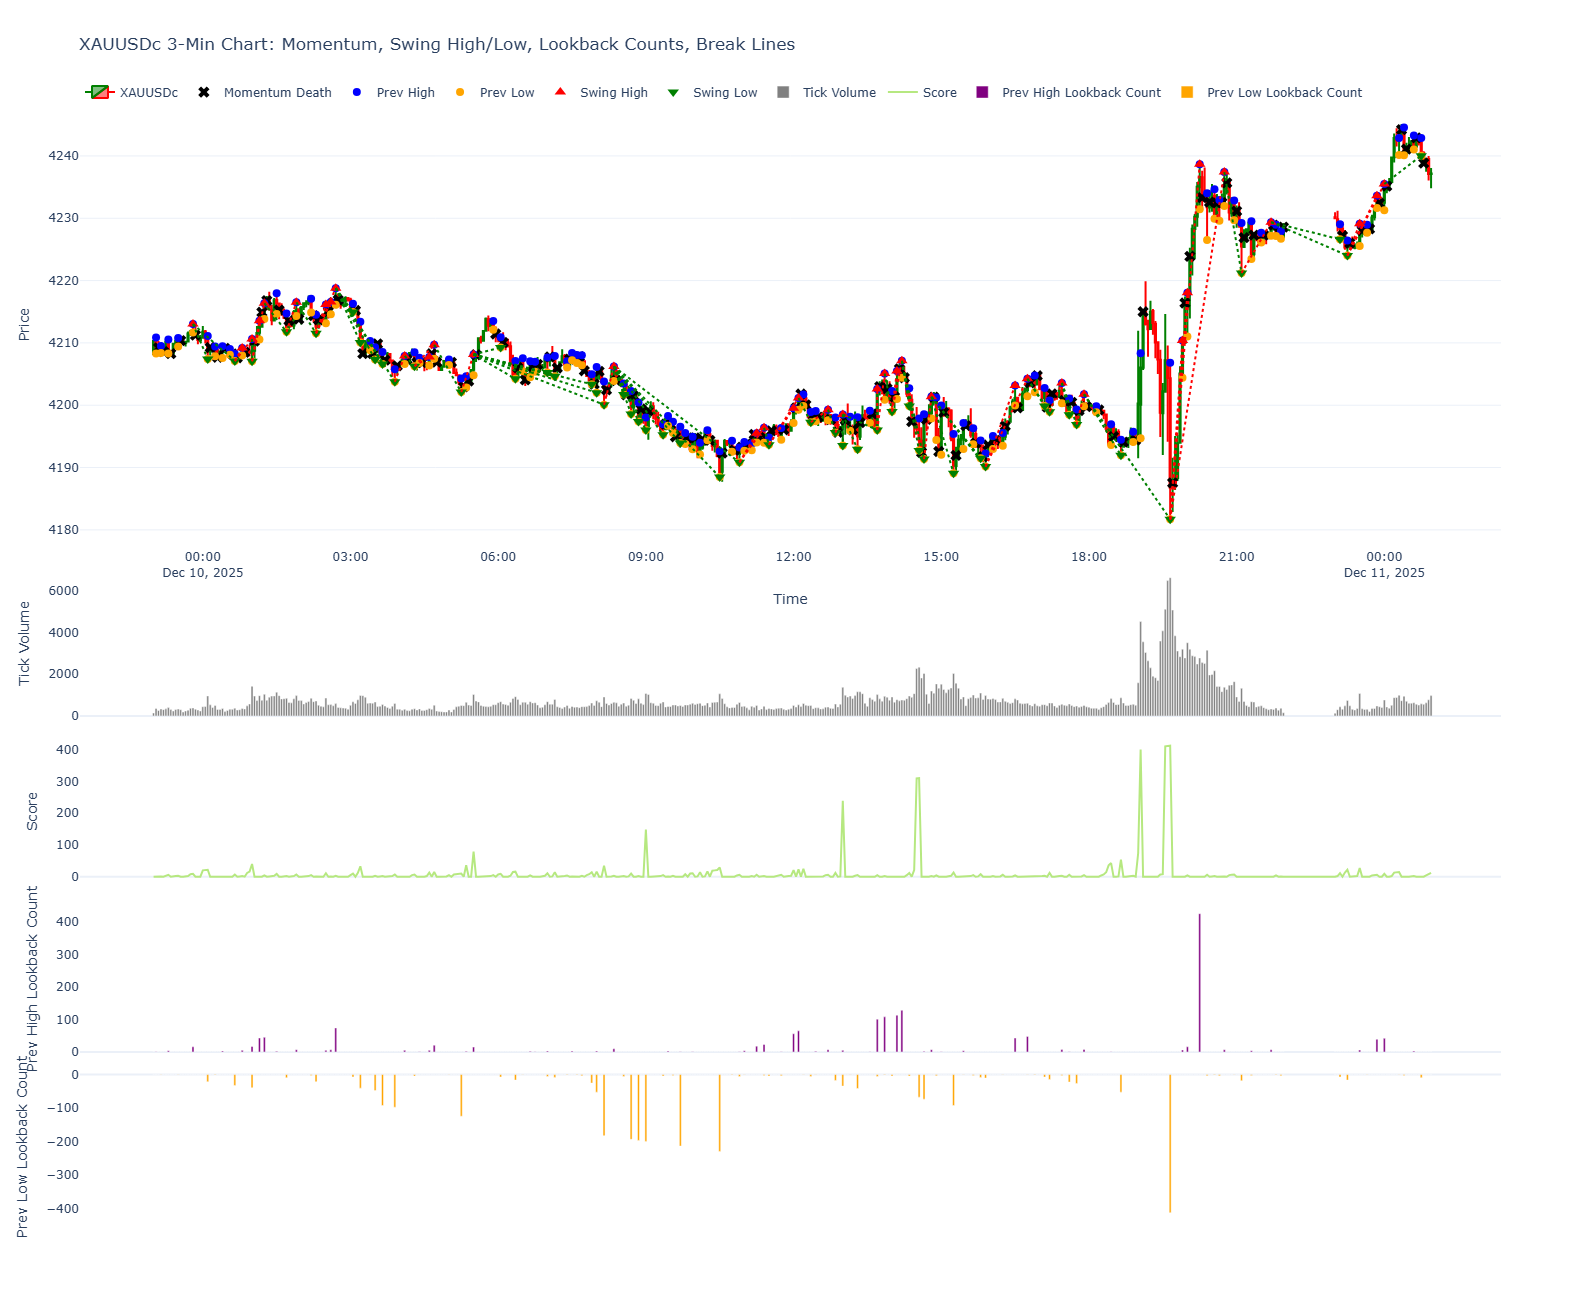

In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=1)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Compute Infinite Lookback Score (momentum)
# -------------------------
scores = [0]
for i in range(1, len(df)):
    curr_vol = df['tick_volume'].iloc[i]
    prev_vol = df['tick_volume'].iloc[i - 1]

    if curr_vol <= prev_vol:
        scores.append(0)
        continue

    score = 0
    j = i - 1
    while j >= 0:
        if df['tick_volume'].iloc[j] < curr_vol:
            score += 1
            j -= 1
        else:
            break
    scores.append(score)
df['score'] = scores

# -------------------------
# 6. Detect Momentum Death Points and prev high/low marks
# -------------------------
momentum_death_x = []
momentum_death_y = []
prev_high_x = []
prev_high_y = []
prev_low_x = []
prev_low_y = []

for i in range(1, len(df)):
    if df['score'].iloc[i - 1] > 0 and df['score'].iloc[i] == 0:
        momentum_death_x.append(df.index[i])
        momentum_death_y.append(df['close'].iloc[i])

        prev_high_x.append(df.index[i - 1])
        prev_high_y.append(df['high'].iloc[i - 1])

        prev_low_x.append(df.index[i - 1])
        prev_low_y.append(df['low'].iloc[i - 1])

# -------------------------
# 7. Compute Infinite-Left Lookback Count for Prev High
# -------------------------
prev_high_lookback_score = np.zeros(len(df))
prev_high_indices = [df.index.get_loc(x) for x in prev_high_x]

for idx in prev_high_indices:
    current_high = df['high'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_high <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_high_lookback_score[idx] = lookback_count
df['prev_high_lookback_score'] = prev_high_lookback_score

# -------------------------
# 8. Compute Infinite-Left Lookback Count for Prev Low (negative)
# -------------------------
prev_low_lookback_score = np.zeros(len(df))
prev_low_indices = [df.index.get_loc(x) for x in prev_low_x]

for idx in prev_low_indices:
    current_low = df['low'].iloc[idx]
    j = idx - 1
    lookback_count = 0
    while j >= 0:
        if df['low'].iloc[j] <= current_low <= df['high'].iloc[j]:
            break
        lookback_count += 1
        j -= 1
    prev_low_lookback_score[idx] = -lookback_count
df['prev_low_lookback_score'] = prev_low_lookback_score

# -------------------------
# 9. Detect Swing Highs and Swing Lows
# -------------------------
swing_high_x = []
swing_high_y = []
swing_low_x = []
swing_low_y = []

for i in range(len(df)):
    if df['prev_high_lookback_score'].iloc[i] >= 5:
        swing_high_x.append(df.index[i])
        swing_high_y.append(df['high'].iloc[i])
    if df['prev_low_lookback_score'].iloc[i] <= -5:
        swing_low_x.append(df.index[i])
        swing_low_y.append(df['low'].iloc[i])

# -------------------------
# 10. Prepare Break Lines Between Swing Points
# -------------------------
break_lines = []

# Combine swing highs and lows into a DataFrame
swings = pd.DataFrame({
    'time': swing_high_x + swing_low_x,
    'price': swing_high_y + swing_low_y,
    'type': ['high'] * len(swing_high_x) + ['low'] * len(swing_low_x)
})
swings = swings.sort_values('time').reset_index(drop=True)

# Connect each swing to nearest previous opposite swing
for i in range(1, len(swings)):
    current = swings.iloc[i]
    for j in range(i - 1, -1, -1):
        prev = swings.iloc[j]
        if prev['type'] != current['type']:
            line_color = 'red' if prev['type'] == 'low' and current['type'] == 'high' else 'green'
            break_lines.append(dict(
                type="line",
                x0=prev['time'],
                y0=prev['price'],
                x1=current['time'],
                y1=current['price'],
                line=dict(color=line_color, width=2, dash='dot'),
                xref="x",
                yref="y",
                layer="above"
            ))
            break

# -------------------------
# 11. Plot 5-pane chart with Swing High/Low and Break Lines
# -------------------------
fig = go.Figure()

# Price pane
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Momentum-death markers
fig.add_trace(go.Scatter(
    x=momentum_death_x,
    y=momentum_death_y,
    mode='markers',
    name='Momentum Death',
    marker=dict(size=10, color='black', symbol='x'),
    yaxis='y'
))

# Prev high/low circles
fig.add_trace(go.Scatter(
    x=prev_high_x,
    y=prev_high_y,
    mode='markers',
    name='Prev High',
    marker=dict(size=8, color='blue', symbol='circle'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=prev_low_x,
    y=prev_low_y,
    mode='markers',
    name='Prev Low',
    marker=dict(size=8, color='orange', symbol='circle'),
    yaxis='y'
))

# Swing High/Low markers
fig.add_trace(go.Scatter(
    x=swing_high_x,
    y=swing_high_y,
    mode='markers',
    name='Swing High',
    marker=dict(size=10, color='red', symbol='triangle-up'),
    yaxis='y'
))
fig.add_trace(go.Scatter(
    x=swing_low_x,
    y=swing_low_y,
    mode='markers',
    name='Swing Low',
    marker=dict(size=10, color='green', symbol='triangle-down'),
    yaxis='y'
))

# Tick Volume pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Momentum score pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['score'],
    mode='lines',
    name='Score',
    marker=dict(size=4),
    yaxis='y3'
))

# Prev High Lookback Count pane
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_high_lookback_score'],
    name='Prev High Lookback Count',
    marker_color='purple',
    yaxis='y4'
))

# Prev Low Lookback Count pane (negative)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['prev_low_lookback_score'],
    name='Prev Low Lookback Count',
    marker_color='orange',
    yaxis='y5'
))

# Layout with 5 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Min Chart: Momentum, Swing High/Low, Lookback Counts, Break Lines',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.60, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.45, 0.58], showgrid=False),
    yaxis3=dict(title='Score', domain=[0.30, 0.43], showgrid=False),
    yaxis4=dict(title='Prev High Lookback Count', domain=[0.15, 0.28], showgrid=False),
    yaxis5=dict(title='Prev Low Lookback Count', domain=[0.00, 0.13], showgrid=False),
    height=1300,
    legend=dict(orientation='h', y=1.02, x=0),
    shapes=break_lines
)

fig.show()
